このノートブックではpythonによるtitanicデータ処理の基本を勉強していきます。<br>
なおここでは、titanic_datasフォルダにデータがあると仮定して進めます。kaggleのkernelを使用している場合、データは../input/にあるので、データのパスをtitanic_darasから../inputに変更してください

<h1>1. データの相関</h1>

まず最初に、<b>pandas</b>というデータ処理用のライブラリを用いてデータを読み込んでみましょう。<br>

In [1]:
import pandas
read_data = pandas.read_csv("titanic_datas/train.csv")

無事にデータを読み込むことはできたでしょうか？できたか確認してみましょう。

In [2]:
read_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


もしうまく読み込めていたら、表のようなものが出力されていると思います。

<b>titanicではどのような人が優先的に救助されたのでしょうか？</b><br>
レディーファーストで、若い女性が優先されて救助されたのは間違いないでしょう。では、生存率を見てみましょう、実際にそうだったのでしょうか？

In [3]:
male_data = read_data[read_data.Sex == "male"]
print(len(male_data[male_data.Survived == 1]) / len(male_data))

female_data = read_data[read_data.Sex == "female"]
print(len(female_data[female_data.Survived == 1]) / len(female_data))

0.18890814558058924
0.7420382165605095


これから女性の生存率がはるかに高いことがわかります。<br>

<b>ではほかの要素はどうでしょうか？例えば年齢などは関係してくるのでしょうか？</b><br>
試しにグラフを書いてみましょう。<br>

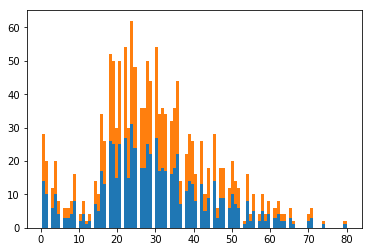

In [4]:
import matplotlib.pyplot as plt

split_data = []
for survived in [0,1]:
    split_data.append(read_data[read_data.Survived==survived])

temp = [read_data.Age.dropna() for i in split_data]
plt.hist(temp, histtype="barstacked", bins=100)
plt.show()

<b>グラフだと若いと生存率が高いように見えます。本当でしょうか？</b><br>
割合を見てみましょう。<br>

In [5]:
read_data.Age.fillna(read_data.Age.median(), inplace=True)
age_list = list(set(map(int, read_data.Age)))
age_list.sort()
age_per = list()
for i in age_list:
    age_data = read_data[read_data.Age == i]
    if len(age_data) != 0:
        age_per.append(len(age_data[age_data.Survived == 1]) / len(age_data))
        print(i, len(age_data[age_data.Survived == 1]) / len(age_data))
    else:
        age_per.append(0)

1 0.7142857142857143
2 0.3
3 0.8333333333333334
4 0.7
5 1.0
6 0.6666666666666666
7 0.3333333333333333
8 0.5
9 0.25
10 0.0
11 0.25
12 1.0
13 1.0
14 0.5
15 0.8
16 0.35294117647058826
17 0.46153846153846156
18 0.34615384615384615
19 0.36
20 0.2
21 0.20833333333333334
22 0.4074074074074074
23 0.3333333333333333
24 0.5
25 0.2608695652173913
26 0.3333333333333333
27 0.6111111111111112
28 0.29207920792079206
29 0.4
30 0.4
31 0.47058823529411764
32 0.5
33 0.4
34 0.4
35 0.6111111111111112
36 0.5
37 0.16666666666666666
38 0.45454545454545453
39 0.35714285714285715
40 0.46153846153846156
41 0.3333333333333333
42 0.46153846153846156
43 0.2
44 0.3333333333333333
45 0.4166666666666667
46 0.0
47 0.1111111111111111
48 0.6666666666666666
49 0.6666666666666666
50 0.5
51 0.2857142857142857
52 0.5
53 1.0
54 0.375
55 0.5
56 0.5
57 0.0
58 0.6
59 0.0
60 0.5
61 0.0
62 0.5
63 1.0
64 0.0
65 0.0
66 0.0
70 0.0
71 0.0
74 0.0
80 1.0


ここで、fillnaメソッドでは、年齢の中央値でNanを埋めています。<br>

<b>なぜ、平均値ではなく中央値なのでしょうか？</b><br>
それは平均値は極端に大きいか小さい値(外れ値)に引き寄せられる性質があるためです。<br>
中央値は全データの中心の値なのでデータの大きさによりません。なので平均値ではなく中央値を使っているのです。

これを折れ線グラフにしてみましょう

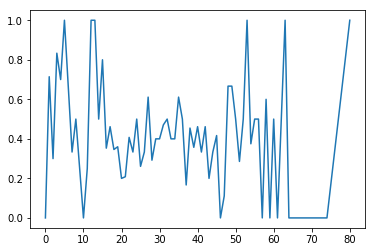

In [6]:
plt.plot(age_list, age_per)
plt.show()

このグラフから、年齢が低いもしくは高い人の生存率が高いことがわかります。<br>

<h1>2. データの解析</h1>

さて、ここまでで、性別および年齢と、生存率の相関がわかりました。<br>
各変数と生存率の相関を見るのはここまでにして、次はデータの解析を行っていきましょう。なお、以下では性別、年齢、社会的階級が生存と関係していたと仮定して話を進めます。

<h2>2.1. ランダムフォレストとサポートベクトルマシン</h2>

この章では、ランダムフォレストとサポートベクトルマシンの仕組みおよび実装の説明をしていきます。<br>
まず最初に、<b>ランダムフォレスト</b>のもととなる<b>決定木</b>という手法について説明と実装を行っていきましょう。<br>

決定木とは、簡単に言えば、データを元にしてデータを分類するルールを作っていく手法です。<br>
では、どのようにして分類するルールを決定しているのでしょうか？それを今から見ていきましょう。<br>

<h3>2.1.1. 決定木</h3>

物事を決定するとき、<b>決定しやすい情報</b>がほしいと思います。<br>

例えば、「政治家」という情報だけでどの政治家であるかを断定するのは難しいでしょう。しかし、これが「大統領」だとどうでしょうか？一気に候補に挙がる人が少なくなるかと思います。<br>
このように、得た情報によって物事の決定のしやすさが大きく変わる事が分かると思います。<br>

コンピュータが人間のように物事を決定できたら楽なのですが、コンピュータは計算しかできないので、どうにかして「情報の大きさ」というものを数学的に表す必要があります。<br>
実はこのようなものを表すのに最適な数学の道具があります。それが<b>情報量</b>です。<br>

情報量Iはつぎのように定義される量です。<br>
$$
\begin{equation*}
I = -log P(x)
\end{equation*}
$$
ここでP(x)はxが起きる確率を表しています。<br>
何故このような式になるのかは、深く考えないようにしてください。「あぁ、数学ではこうやって情報の大きさを表すんだな」という理解だけで十分です。<br>

情報量はある物事が起きた時に得られる情報の大きさを表しています。しかし、ここで欲しいのは<b>「一回情報を取得した時に得られる情報の期待値を最小にする物事」です。</b><br>
なぜこれを最小にしたいのでしょうか？先ほどの例を引き合いに出して考えると、政治家の母数よりも大統領の母数のほうが少ないですよね？このような情報では当然得られる情報量は少ないでしょう。つまり、情報量が少なくなるように情報を選ぶと、少ない回数で物事を決定できるのです。<br>

では、一回に得られる情報量の期待値とは、どのように計算したら良いでしょうか？

ここで一度<b>期待値</b>を思い出してみましょう。<br>
期待値を覚えていますか？覚えていない方もいるかもしれませんが大丈夫です、これから思い出しましょう。<br>
期待値Eとはある事象Xに対する確率P(X)とある事象Xに対応する関数の値f(X)に対して
$$
\begin{equation*}
E= \sum_{X}^{}P(X)f(X)
\end{equation*}
$$
で表せる量です。<br>
これは一回物事が起きた時に得られる平均のf(X)の値を表しています。<br>

つまりこれに先ほどの情報量の定義式を入れれば一回に得られる平均の情報量Hがわかることになります。したがって
$$
\begin{equation*}
H = \sum_{X}^{} -P(X)log P(X)
\end{equation*}
$$
を得ます。これを平均情報量(エントロピー)といいます。

以上をふまえて、まずはエントロピーを計算する関数を作ってみましょう。

In [7]:
def entropy(probabilities):
    return sum(-p * math.log(p,2) for p in probabilities if p)

どうでしょうか？ただ式をプログラムにするだけなので難しくなかったと思います。難しかったという方も大丈夫、僕もこれを書くとき悩みましたから。<br>

このプログラムでは確率を用います。なので、データからあるデータが出てくる確率を計算する関数を作ってみましょう。<br>
ここで注意が必要で、<b>確率の総和は1でなければなりません。</b>ここだけは注意してください。

In [8]:
def probabilities(labels):
    total_count = len(labels)
    return [count / total_count for count in Counter(labels).values()]   

これもそこまで難しくないかと思います。<b>ただし、Counterというクラスを使用していることに注意してください。</b>これは組み込み型で、Pythonで集計などを行うときに便利な型なので、覚えておくと良いかもしれません。

ここまでで、エントロピーを計算する関数と、確率を計算するプログラムができました。次に、データを受け取り、そのデータから各データのエントロピーを計算するプログラムを書いてみましょう。
ここではひとまず、データの構造は、最初にtuple型でデータ、次に答えを受け取るtuple型のlistとします。

    [
        (data, answer),
        (data, answer),
        ...
    ]

In [9]:
def data_entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    p = probabilities(labels)
    return entropy(p)

次に、分割されたデータのエントロピーを計算しましょう。

In [10]:
def partition_entropy(subsets):
    total_count = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

続いて、与えられたキーでデータを分割する関数を作ってみましょう。つまり<br>

    [
        {1:2, 2:3}
        {1:3, 2:6}
        {1:2, 2:5}
    ]
    
というデータが与えられたとき、この関数にキーである1を与えると<br>

    {
    2:[{1:2, 2:3}, {1:2, 2:5}],
    4:[{1:3, 2:6}],
    }
    
などと帰ってくる関数です。なお、与えられたキーに対応するデータを、出力のdictのキーとします。

In [11]:
def partition_by(inputs, attribute):
    groups = dict()
    for input in inputs:
        key = input[0][attribute]
        if not key in groups:
            groups[key] = list()
        groups[key].append(input)
    return groups

ここまでで、分割されたデータのエントロピーの計算、データの分割まで関数を作成しました。<br>
次に与えられたキーでデータを分割し、分割したデータのエントロピーを計算する関数を作ってみましょう。

In [12]:
def calcurate_entropy(inputs, attribute):
    partitions = partition_by(inputs, attribute)
    #print(partitions.values())
    return partition_entropy(partitions.values())

ではこれらはきちんと動くのでしょうか？<br>
実際に年齢と性別のエントロピーを計算して確認してみましょう

In [4]:
from collections import Counter, defaultdict
import math

data_key =["Age","Sex"]

train = [({key:read_data.T[index][key] for key in data_key}, read_data.T[index]["Survived"]) for index in read_data.T]

for key in data_key:
    print(key, calcurate_entropy(train, key))

NameError: name 'calcurate_entropy' is not defined

何らかの値が計算できたと思います。<br>
最初に書いてあるように、エントロピーが最小になるようにルールを決定したらよいので、この場合最初に性別で分けるのが良いことがわかります。

ここまでで、ルールを決定する方法を説明しました。<br>
しかしこれらのルールをいちいち計算して、人間の手で作成していくのは非効率的です。<br>
なのでルールを自動的に計算する関数を再帰を使って作りましょう。

手順としては、まずデータ数、Survivedが1であるデータ数、Survivedが0であるデータ数を計算します。<br>

Survivedが0,1であるデータ数のどちらかが0になったとき、データが決定されるので、ここでそのルールの生成を止めます。<br>
もしsplit_candidatesがFalseの場合、つまり分割の候補がない場合、より多いデータを返します。

それ以外の時、最小のエントロピーを持つキーでルールを生成したらよいので、最小のエントロピーを持つキーを計算します。<br>
そして、その最小のキーの中に存在するデータを分割し、分割したデータをもとに、そのデータからさらにルールの生成などを再帰的に行うことで自動生成ができます。<br>

In [14]:
from functools import partial

def build_tree(inputs, split_candidates=None):
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()
    
    num_inputs = len(inputs)
    num_1 = len([label for item, label in inputs if label == 1])
    num_0 = num_inputs - num_1
    
    if num_1 == 0:
        return 0
    if num_0 == 0:
        return 1
    if not split_candidates:
        return 1 if num_1 >= num_0 else 0
    
    best_attribute = min(split_candidates, key=partial(calcurate_entropy, inputs))
    
    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates if a != best_attribute]
    
    sub_trees = {attribute_value : build_tree(subset, new_candidates) for attribute_value, subset in partitions.items()}
    sub_trees[None] = 1 if num_1 > num_0 else 0
    
    return best_attribute, sub_trees

では、決定木を作ってみましょう。

In [15]:
tree = build_tree(train)
tree

('Sex',
 {'male': ('Age',
   {22.0: 0,
    35.0: 0,
    28.0: 0,
    54.0: 0,
    2.0: 0,
    20.0: 0,
    39.0: 0,
    34.0: 0,
    19.0: 0,
    40.0: 0,
    66.0: 0,
    42.0: 0,
    21.0: 0,
    7.0: 0,
    65.0: 0,
    28.5: 0,
    11.0: 0,
    45.0: 0,
    4.0: 0,
    26.0: 0,
    32.0: 0,
    25.0: 0,
    0.83: 1,
    29.0: 0,
    16.0: 0,
    24.0: 0,
    46.0: 0,
    59.0: 0,
    71.0: 0,
    23.0: 0,
    33.0: 0,
    37.0: 0,
    38.0: 0,
    47.0: 0,
    70.5: 0,
    32.5: 0,
    12.0: 1,
    18.0: 0,
    27.0: 1,
    36.5: 0,
    51.0: 0,
    55.5: 0,
    40.5: 0,
    30.0: 0,
    44.0: 0,
    17.0: 0,
    1.0: 1,
    9.0: 1,
    61.0: 0,
    56.0: 0,
    36.0: 0,
    3.0: 1,
    45.5: 0,
    20.5: 0,
    62.0: 0,
    52.0: 0,
    23.5: 0,
    0.92: 1,
    43.0: 0,
    15.0: 0,
    50.0: 0,
    64.0: 0,
    31.0: 0,
    49.0: 1,
    48.0: 1,
    58.0: 0,
    55.0: 0,
    8.0: 1,
    60.0: 0,
    57.0: 0,
    80.0: 1,
    70.0: 0,
    24.5: 0,
    14.0: 0,
    6.0: 1,
    0.6

これをもとにデータを分類してみたいと思います。
そのために、分類木とデータからデータを分類する関数を作ってみましょう

In [16]:
def classify(tree, input):
    if tree in [0, 1]:
        return tree
    
    attribute, subtree_dict = tree
    subtree_key = input.get(attribute)
    
    if not subtree_key in subtree_dict:
        subtree_key = None
    
    subtree = subtree_dict[subtree_key]
    return classify(subtree, input)

この関数にデータを入れましょう。

In [17]:
read_test_data = pandas.read_csv("titanic_datas/test.csv")

input_data = [{key:read_data.T[index][key] for key in data_key} for index in read_data.T]
result = [classify(tree, input_data[i]) for i in range(len(read_test_data))]

read_test_data["Survived"] = result 
read_test_data[["PassengerId","Survived"]].to_csv("titanic_datas/submission.csv",index=False)

<h3>2.1.2. ランダムフォレスト</h3>

<b>ここまでで、提出用のデータまで作成することができました。</b><br>

しかし、提出はちょっと待ってください。これを提出しても0.55くらいのスコアしか出ません。<br>
なぜかというと、この学習したデータのみに適応した決定木が作成されているためです。<br>
これに対してどのように対処したらよいでしょうか？

実はこれに対応するために作られたアルゴリズムがあります、それが<b>ランダムフォレスト</b>です。<br>
ではランダムフォレストはどのように実装したらよいでしょうか？<br>

今まで自分でコードを書いてきました。しかし、pythonにおいて重要なことが一つあります。<br>
それはpythonで何かやりたいとき、まず最初にやりたいことをするライブラリがあるか探そうというものです。<br>
今回、決定木やランダムフォレストを実装しましたが、これらもライブラリが存在します。<br>
それが機械学習についての関数やクラスをまとめた<b>scikit-learn</b>です。

ではscikit-learnを使ってランダムフォレストを実装して、結果をsubmitしてみましょう。

In [18]:
from sklearn.ensemble import RandomForestClassifier

read_data = read_data.replace("male", 0).replace("female", 1)
read_data["Age"].fillna(read_data.Age.median(), inplace=True)

forest = RandomForestClassifier()
forest.fit(read_data[data_key], read_data["Survived"])

read_test_data = pandas.read_csv("titanic_datas/test.csv").replace("male", 0).replace("female", 1)
read_test_data["Age"].fillna(read_test_data.Age.median(), inplace=True)

pre =  forest.predict(read_test_data[data_key])
read_test_data["Survived"] = pre
read_test_data[["PassengerId","Survived"]].to_csv("titanic_datas/submission_scikit_random_forest.csv",index=False)

<h3>2.1.3. サポートベクターマシン</h3>
サポートベクターマシン(SVM)は簡単に言うと、データを最もきれいに分割できる線を見つけるための手法です。<br>
ではどのようにして、この線を導けばよいでしょうか？<br>
この話はかなり高度な数学的な理論を話さなければならなくなるため簡単にしか説明しませんが、線と最も近い点の距離(マージン)を最大にするような線を見つければ最もきれいに分割できます。<br>

SVMの強みとして、カーネルというものを取り込むだけで非線形なものを分類できるというところにあります。<br>

この手法はよく使われる手法なので覚えておくほうが良いでしょう。<br>

ではまずSVMを使用して線形に分類させたいと思います。

In [19]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
lsvc.fit(read_data[data_key], read_data["Survived"])

read_test_data = pandas.read_csv("titanic_datas/test.csv").replace("male",0).replace("female",1)

read_test_data["Age"].fillna(read_data["Age"].median(), inplace=True)

pre = lsvc.predict(read_test_data[data_key])
read_test_data["Survived"] = pre
read_test_data[["PassengerId","Survived"]].to_csv("titanic_datas/submission_LinearSVC.csv",index=False)

次にカーネルを使用して、非線形なものを分類させたいと思います。<br>
今回はRBFカーネル(ガウスカーネル)というものを使用します。

In [22]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf")
clf.fit(read_data[data_key], read_data["Survived"])

read_test_data = pandas.read_csv("titanic_datas/test.csv").replace("male",0).replace("female",1)
read_test_data["Age"].fillna(read_data["Age"].median(), inplace=True)

pre = clf.predict(read_test_data[data_key])

read_test_data["Survived"] = pre
read_test_data[["PassengerId","Survived"]].to_csv("titanic_datas/submission_svc.csv",index=False)

SVMではパラメーターの調整で性能が大きく変わります。しかし、それらを1から10まですべて行おうとすると、かなりの時間と労力を使用します。<br>
そこでscikit-learnでは各パラメーターを試し、性能を調べるGridSearchCVという関数が用意されています。<br>
試しに使用してみたいと思います。

注意:ご使用のパソコンによっては時間がかかる可能性があります。

In [ ]:
import numpy
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

#tuned_parameters = [
#    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
#    ]

tuned_parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]}
    ]

read_data = read_data.replace("male", 0).replace("female", 1)
read_data["Age"].fillna(read_data.Age.median(), inplace=True)

print("Setting GridSearch")
clf = GridSearchCV(SVC(), tuned_parameters, cv=5, n_jobs=-1)
print("Start GridSearch")
clf.fit(read_data[data_key], read_data["Survived"])

print(clf.best_estimator_)
print("------------------")
print(clf.grid_scores_)

Setting GridSearch
Start GridSearch
